In [1]:
import open3d as o3d
import numpy as np
import math, pandas, pickle
import scipy
from scipy import sparse
from sklearn.neighbors import KDTree
from sklearn.metrics.pairwise import euclidean_distances
import gudhi as gd
from gudhi.weighted_rips_complex import WeightedRipsComplex
from gudhi.dtm_rips_complex import DTMRipsComplex
from ripser import ripser
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from gudhi.tensorflow import RipsLayer
import plotly.graph_objects as go
import ot.plot
import matplotlib.pylab as pl
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from utilyze import *
import pickle
from matplotlib.lines import Line2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from scipy.stats import pearsonr

In [2]:
random_seed()
# Raw data is downloaded from '# https://gitlab.com/alexpieloch/PersistentHomologyAnalysisofBrainArteryTrees/-/tree/master/data/OriginalBrainTreeData'

# To save computation time, first subsample 98 point clouds, each consisting of 2000 points.
# Then compute the ICP-Wasserstein distance matrix for these 98 point clouds.
# For each point cloud X, find the ICP-Wasserstein-closest point cloud Y. Compute the difference vector (estimated gradient).
# Subsample 3 point clouds from X and the corresponding gradient vectors.

# Load data
data_pc = np.load("Data/data_pc.pkl", allow_pickle=True)
print('Original pointcloud size:',data_pc[0].shape)
# Subsample
number_pts = 2000 
data_pc_subsample = []
for i in range(len(data_pc)):
    if i not in [40, 45]:
        pc = data_pc[i]
        all_idx = np.random.permutation(pc.shape[0])
        for j in range(1):
            small_idx = all_idx[int(j * number_pts) : int((j+1) * number_pts)]
            pc_sub = pc[small_idx]
            # normalize
            centered_pc_sub = np.copy(pc_sub)
            centered_pc_sub[:,0] -= np.mean(pc_sub[:,0])
            centered_pc_sub[:,1] -= np.mean(pc_sub[:,1])
            centered_pc_sub[:,2] -= np.mean(pc_sub[:,2])
            data_pc_subsample.append(centered_pc_sub)
data_pc = data_pc_subsample
# Normalize
mean_max = np.mean([np.max(abs(data_pc[i]),axis=0) for i in range(len(data_pc))])
for i in range(len(data_pc)):
    data_pc[i] /= mean_max * 2
print('Randomness check: [88916 11866 12750 14216 86734]',  all_idx[:5])
print('Number of data: ',len(data_pc))
print('Sampled pc size: ',data_pc[0].shape)

# Load sex features
df = pandas.read_csv('Data/label.csv')
gender = np.array(df['gender'])
label = []
for i in range(gender.shape[0]):
    if i not in [48,50,63,66,69,72,78,84,98,101,103]:
        label.append(gender[i])
labels_raw=np.array(label)
labels_raw -= 1
labels = []
for i in range(len(labels_raw)):
    if i not in [40, 45]:
        label_pc = labels_raw[i]
        for j in range(1):
            labels.append(label_pc)
labels = np.array(labels)

Original pointcloud size: (116361, 3)
Randomness check: [88916 11866 12750 14216 86734] [88916 11866 12750 14216 86734]
Number of data:  96
Sampled pc size:  (2000, 3)


In [3]:
# compute the ICP-Wasserstein distance matrix
n = len(data_pc)
distance_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(i, n):
        pc1,pc2 = data_pc[i],data_pc[j]
        pc1_regis = find_align(pc1, pc2)
        M = ot.dist(pc1_regis, pc2)
        d1,d2 = np.ones((number_pts,)) / number_pts, np.ones((number_pts,)) / number_pts
        emd = ot.emd(d1,d2,M, numItermax=1e6) #default numItermax 1e5
        W = np.sum(emd * M)
        distance_matrix[i][j] = W
        distance_matrix[j][i] = W

In [4]:
# Gradient estimate
data_grad = []
data_pc_real = []
number_pts_real = 500
for i,pc in enumerate(data_pc):
    # find the neareast pc with diff label
    label = labels[i]
    index_otherclass = np.where(labels!=label)[0]
    distances_otherclass = np.array([distance_matrix[i, j] for j in index_otherclass])
    j = index_otherclass[np.argmin(distances_otherclass)]
    # find the OT vector
    pc1 = data_pc[i]
    pc2 = data_pc[j]
    pc1_regis = find_align(pc1, pc2)
    M = ot.dist(pc1_regis, pc2)
    n = pc1_regis.shape[0]
    d1,d2 = np.ones((n,)) / n, np.ones((n,)) / n
    emd = ot.emd(d1,d2,M)
    indices = np.argwhere(emd == np.max(emd))
    vec = [pc2[l] - pc1_regis[k] for k, l in indices]
    vec = np.array(vec)
    random_seed()
    all_idx = np.random.permutation(pc1_regis.shape[0])
    for iter in range(3):
        small_idx = all_idx[number_pts_real*iter: number_pts_real*(iter+1)]
        pc_real = pc1_regis[small_idx]
        vec_real = vec[small_idx]
        vec_real = np.array(vec_real).reshape(-1,)
        data_grad.append(vec_real)
        data_pc_real.append(pc_real)

data_pc = data_pc_real

In [3]:
# compute pull-back norms
xrange = [.0, .25]
yrange = [.0, .25]
maximum_edge_length = .25
number_pixel = 20
gauss_sigma = 3e-5 
weight_s = 0.065
weight_mus = [0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15]

Pbn = {}
Rank = {}
for weight_mu in weight_mus:
    Pbn[weight_mu] = []
    Rank[weight_mu] = []
    
np.random.seed(50)
minisize = len(data_pc)
idx = np.random.permutation(len(data_pc))[:minisize]
for weight_mu in weight_mus:
    random_seed()
    weightfunc = Weight(method='beta', m=weight_mu, s=weight_s) 
    jacobians, pis, ranks = Collect_jacobian_and_rank_and_pi(np.array(data_pc)[idx], get_jacobian_rips, xrange, yrange,
                                            number_pixel=number_pixel, gauss_sigma=gauss_sigma, 
                                            weight_func = weightfunc, max_edge_length=maximum_edge_length, 
                                            homology_dimensions=[1], normalize=False, normalize_jac=True, lapack_driver='gesvd')
    grads = np.array(data_grad)[idx]
    Pbn[weight_mu] = [np.linalg.norm(jacobians[k] @ grads[k]) for k in range(minisize)]
    Rank[weight_mu] = ranks
    print(weight_mu)

2024-02-28 19:28:15.927270: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15


In [4]:
# prepare data for downstream task
Data = []
for weight_mu in weight_mus:
    weightfunc = Weight(method='beta', m=weight_mu, s=weight_s)
    data_pi = Collect_pi(data_pc, xrange, yrange, number_pixel=number_pixel, gauss_sigma=gauss_sigma, weight_func = weightfunc, max_edge_length=maximum_edge_length, homology_dimensions=[1], normalize=False)            
    Data.append(data_pi)

df = pandas.read_csv('Data/label.csv')
gender = np.array(df['gender'])
label = []
for i in range(gender.shape[0]):
    if i not in [48,50,63,66,69,72,78,84,98,101,103]:
        label.append(gender[i])
labels_raw=np.array(label)
labels_raw -= 1

labels = []
for i in range(len(labels_raw)):
    if i not in [40, 45]: # remove label 3, 4
        label_pc = labels_raw[i]
        for j in range(3):
            labels.append(label_pc)        
labels = np.array(labels)

In [8]:
from sklearn.metrics import log_loss

def train_lr(train_data, train_labels, val_data, val_labels, noise_level = .005, C=1):
    random_seed()
    if C == None:
        lr = LogisticRegression(max_iter=1000, penalty=None) #solver    
    else:
        lr = LogisticRegression(max_iter=300, C=C) #solver
        
    lr.fit(train_data, train_labels)
    test_accuracy = accuracy_score(val_labels, lr.predict(val_data))
    test_loss = log_loss(val_labels, lr.predict_proba(val_data))
    train_accuracy = accuracy_score(train_labels, lr.predict(train_data))
    train_loss = log_loss(train_labels, lr.predict_proba(train_data))
    #robust test
    val_data_noisy = val_data + np.random.normal(0,noise_level, size = val_data.shape)
    robust_test_loss = log_loss(val_labels, lr.predict_proba(val_data_noisy))
    robust_test_accuracy = accuracy_score(val_labels, lr.predict(val_data_noisy))
    return train_loss, train_accuracy, test_loss, test_accuracy, robust_test_loss, robust_test_accuracy

In [9]:
my_num_split, my_C = 7, 1
Testacc, Robustacc = {}, {}
for weight_mu in weight_mus:
    Testacc[weight_mu] = []
    Robustacc[weight_mu] = []
random_seed()
kf = KFold(n_splits=my_num_split, shuffle=True, random_state=86)
for ii, weight_mu in enumerate(weight_mus):
    data_pi = Data[ii]
    # data_pi /= np.max(data_pi) # normalize feature <-> normal jac
    scaler = StandardScaler().fit(data_pi)
    data_pi = scaler.transform(data_pi)
    for train_index, test_index in kf.split(data_pi):
        train_pi, val_pi = data_pi[train_index], data_pi[test_index]
        train_labels, val_labels = labels[train_index], labels[test_index]
        train_loss, train_accuracy, test_loss, test_accuracy, robust_test_loss, robust_test_accuracy = train_lr(train_pi, train_labels, val_pi, val_labels, C=my_C)
        Testacc[weight_mu].append(test_accuracy)
        Robustacc[weight_mu].append(robust_test_accuracy)

pbn_list = np.array([np.mean(Pbn[key]) for key in weight_mus]).reshape(-1)
acc_list = np.array([np.mean(Testacc[key]) for key in weight_mus]).reshape(-1)
rank_list = np.array([np.mean(Rank[key]) for key in weight_mus]).reshape(-1)
pearsonr(pbn_list, acc_list), pearsonr(rank_list, acc_list)

(PearsonRResult(statistic=0.8918945663486031, pvalue=0.0012287181531005608),
 PearsonRResult(statistic=0.5051911316502289, pvalue=0.16536359351850047))

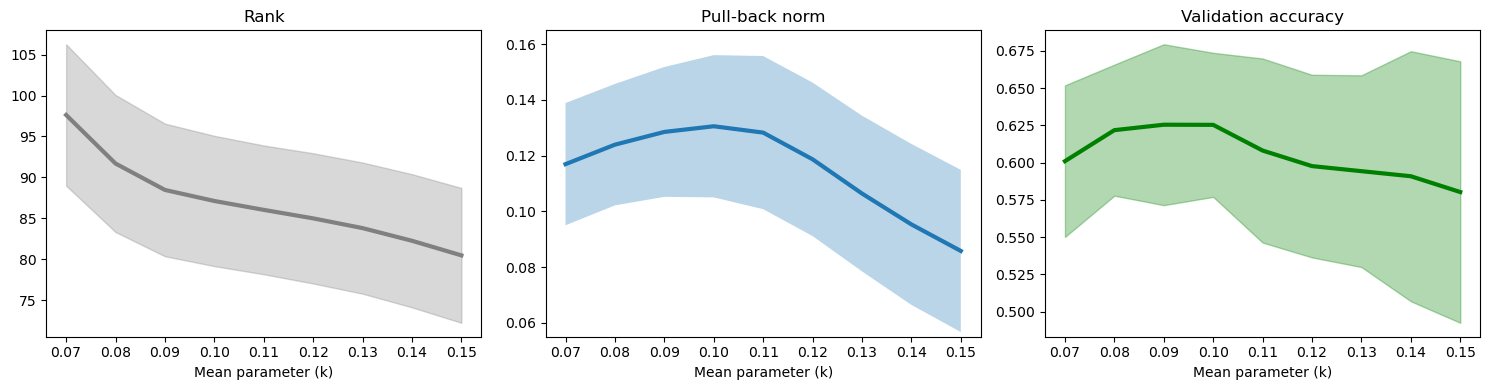

In [10]:
fig, axs = plt.subplots(1,3,figsize=(15,4))
axs[0].plot(weight_mus, np.array([np.mean(Rank[key]) for key in weight_mus]), color='grey', linewidth=3)
axs[0].fill_between(weight_mus, np.array([np.std(Rank[key]) for key in weight_mus])+ np.array([np.mean(Rank[key]) for key in weight_mus]), -np.array([np.std(Rank[key]) for key in weight_mus])+ np.array([np.mean(Rank[key]) for key in weight_mus]), alpha=.3, color='grey')
axs[0].set_title('Rank') 
axs[0].set_xlabel('Mean parameter (k)') 

axs[1].plot(weight_mus, np.array([np.mean(Pbn[key]) for key in weight_mus]), linewidth=3)
axs[1].fill_between(weight_mus, np.array([np.std(Pbn[key]) for key in weight_mus])+ np.array([np.mean(Pbn[key]) for key in weight_mus]), -np.array([np.std(Pbn[key]) for key in weight_mus])+ np.array([np.mean(Pbn[key]) for key in weight_mus]), alpha=.3)
axs[1].set_title('Pull-back norm')
axs[1].set_ylim(0.055, 0.165)
axs[1].set_xlabel('Mean parameter (k)') 

weight_mus_new = weight_mus
axs[2].plot(weight_mus_new, np.array([np.mean(Testacc[key]) for key in weight_mus_new]), color='green', linewidth=3)
axs[2].fill_between(weight_mus_new, np.array([np.std(Testacc[key]) for key in weight_mus_new])+ np.array([np.mean(Testacc[key]) for key in weight_mus_new]), -np.array([np.std(Testacc[key]) for key in weight_mus_new])+ np.array([np.mean(Testacc[key]) for key in weight_mus_new]), color='green', alpha=.3)
axs[2].set_title('Validation accuracy')
axs[2].set_xlabel('Mean parameter (k)') 

plt.tight_layout()
plt.savefig('Figure/weightfunc.png', dpi=300)